# Create climate dataset for capitals in Europe

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
import pandas as pd
import numpy as np
%matplotlib inline

# to resolve xarray FutureWarning
xr.set_options(use_new_combine_kwarg_defaults=True)

In [47]:
# Check all available datasets first
eu_capitals = pd.read_csv("datasets/eu_capitals.csv")
print(eu_capitals.shape)
eu_capitals.head()

(58, 3)


,name,latitude,longitude
0,Mariehamn,60.00,20.00
1,Tirana,41.25,19.75
2,Andorra la Vella,42.50,1.50
3,Yerevan,40.25,44.50
4,Vienna,48.25,16.25


In [29]:
bern = eu_capitals[eu_capitals['name'] == 'Bern']
display(bern)

,name,latitude,longitude
53,Bern,47.0,7.5


In [30]:
# Check all available datasets first
all_datasets = cfgrib.open_datasets("1970_2020.grib")
print(f"Number of datasets: {len(all_datasets)}\n")

for i, dataset in enumerate(all_datasets):
    print(f"Dataset {i}:")
    print(f"  Variables: {list(dataset.data_vars)}")
    print(f"  Dimensions: {dict(dataset.sizes)}")

Number of datasets: 2

Dataset 0:
  Variables: ['sf', 'tp']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}
Dataset 1:
  Variables: ['t2m', 'si10']
  Dimensions: {'time': 612, 'latitude': 149, 'longitude': 281}


In [31]:
all_datasets = cfgrib.open_datasets("1970_2020.grib")

# Dataset 0 contains: sf, tp
# Dataset 1 contains: t2m, si10
# Each dictionary entry is a cube
ds = {
    'sf': all_datasets[0].sf,
    'tp': all_datasets[0].tp,
    't2m': all_datasets[1].t2m,
    'si10': all_datasets[1].si10
}

print("Loaded variables:", list(ds.keys()))
print(f"Dimensions: time={len(all_datasets[0].time)}, lat={len(all_datasets[0].latitude)}, lon={len(all_datasets[0].longitude)}")

Loaded variables: ['sf', 'tp', 't2m', 'si10']
Dimensions: time=612, lat=149, lon=281


Tha data retrieved from Copernicus are in the form of 4D-hypercubes with dimensions: feature, time, latitude, longitude (4 x 612 x 58 x 58). To visualize it, you can think of a 3D cube linked to each feature (sf, tp, t2m, si10). The 3 dimensions are: time (monthly data from 1970 to 2020), latitude, longitude.

![](images/data_cubes.png)

In [32]:
features = ["sf", "t2m", "tp", "si10"]

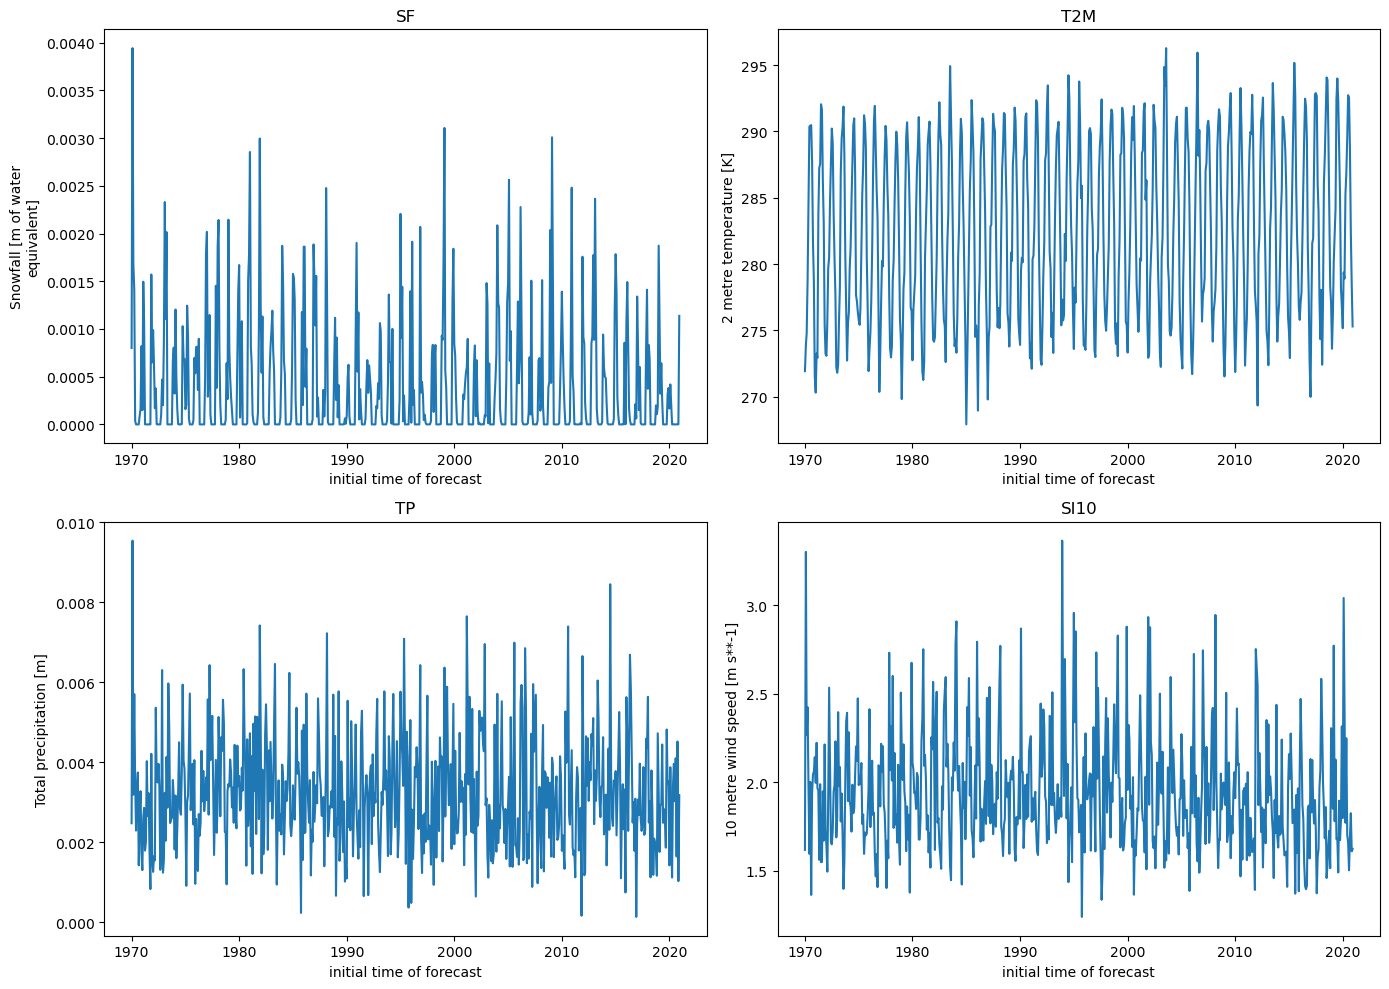

In [33]:
# Plot time series for each feature at Bern's location

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(features):
    ds[feat].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0]).plot(ax=axes[i])
    axes[i].set_title(f'{feat.upper()}')

plt.tight_layout()
plt.show()

In [34]:
ds["sf"].sel(longitude=bern.longitude.values[0], latitude=bern.latitude.values[0])

<xarray.DataArray 'sf' (time: 612)> Size: 2kB
[612 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 5kB 1969-12-31T18:00:00 ... 2020-11-30T...
    number      int64 8B 0
    step        timedelta64[ns] 8B 12:00:00
    surface     float64 8B 0.0
    latitude    float64 8B 47.0
    longitude   float64 8B 7.5
    valid_time  (time) datetime64[ns] 5kB ...
Attributes: (12/31)
    GRIB_paramId:                             144
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      41869
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_shortName:                           sf
    GRIB_totalNumber:                         0
    GRIB_units:                               m of water equivalent
    long_name:                                Snowfall
    units:                                    m of water equivalent
    standard_name:                            lwe_thickness_of_snowfall_amount

In [35]:
# Keep only the data linked to the european capitals

eu_capitals_sorted = eu_capitals.sort_values(['latitude', 'longitude'])

# Extract coordinates as arrays
lats = eu_capitals_sorted['latitude'].values
lons = eu_capitals_sorted['longitude'].values
names = eu_capitals_sorted['name'].values

# Create a subset of ds with only the capitals' coordinates
ds_capitals = {}

for feat in features:
    # Select all capitals at once
    ds_capitals[feat] = ds[feat].sel(
        latitude=xr.DataArray(lats, dims='latitude'),
        longitude=xr.DataArray(lons, dims='longitude'),
        method='nearest'
    )

# Verify
print(f"Original dimensions: {ds['t2m'].dims}")
print(f"Original shape: {ds['t2m'].shape}")
print(f"Subset dimensions: {ds_capitals['t2m'].dims}")
print(f"Subset shape: {ds_capitals['t2m'].shape}")

# You can access data by capital name
print(f"\nData for first capital ({eu_capitals.iloc[0]['name']}):")
print(f"Latitude: {ds_capitals['t2m'].latitude.values[0]}")
print(f"Longitude: {ds_capitals['t2m'].longitude.values[0]}")

Original dimensions: ('time', 'latitude', 'longitude')
Original shape: (612, 149, 281)
Subset dimensions: ('time', 'latitude', 'longitude')
Subset shape: (612, 58, 58)

Data for first capital (Mariehamn):
Latitude: 35.25
Longitude: 33.25


In [36]:
# We see that we still have 612 time steps for 58 lat/lon = capitals
ds_capitals["t2m"]

<xarray.DataArray 't2m' (time: 612, latitude: 58, longitude: 58)> Size: 8MB
[2058768 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
  * latitude    (latitude) float64 464B 35.25 35.25 36.0 ... 62.0 64.25 72.0
  * longitude   (longitude) float64 464B 33.25 33.25 14.5 ... -6.75 -22.0 15.75
    number      int64 8B 0
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 5kB ...
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      41869
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

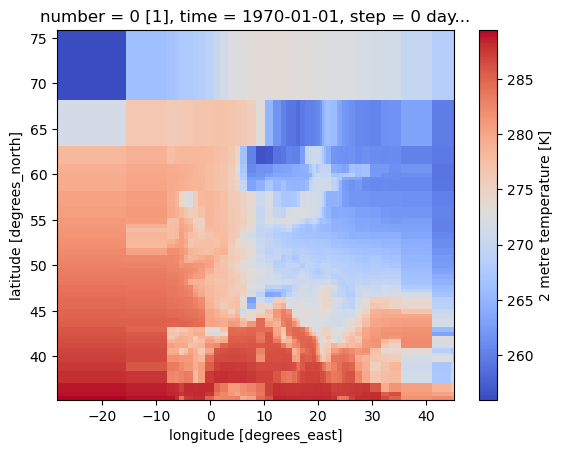

In [37]:
# Plot the temperature data for the first time step across all capitals
ds_capitals["t2m"][0].sortby(['latitude', 'longitude']).plot(cmap=plt.cm.coolwarm)

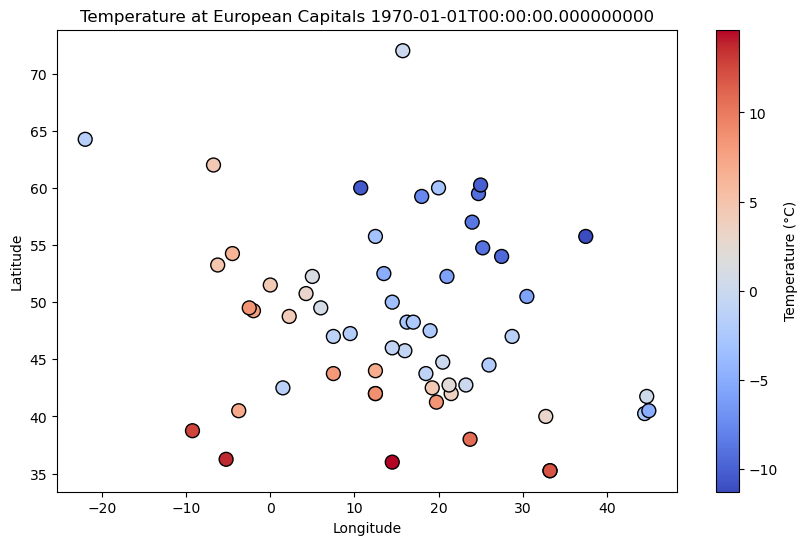

In [38]:
plt.figure(figsize=(10, 6))

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

plt.scatter(lons, lats, c=temps, cmap=plt.cm.coolwarm, s=100, edgecolors='black')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Temperature at European Capitals {ds_capitals["t2m"].time.values[0]}')
plt.show()

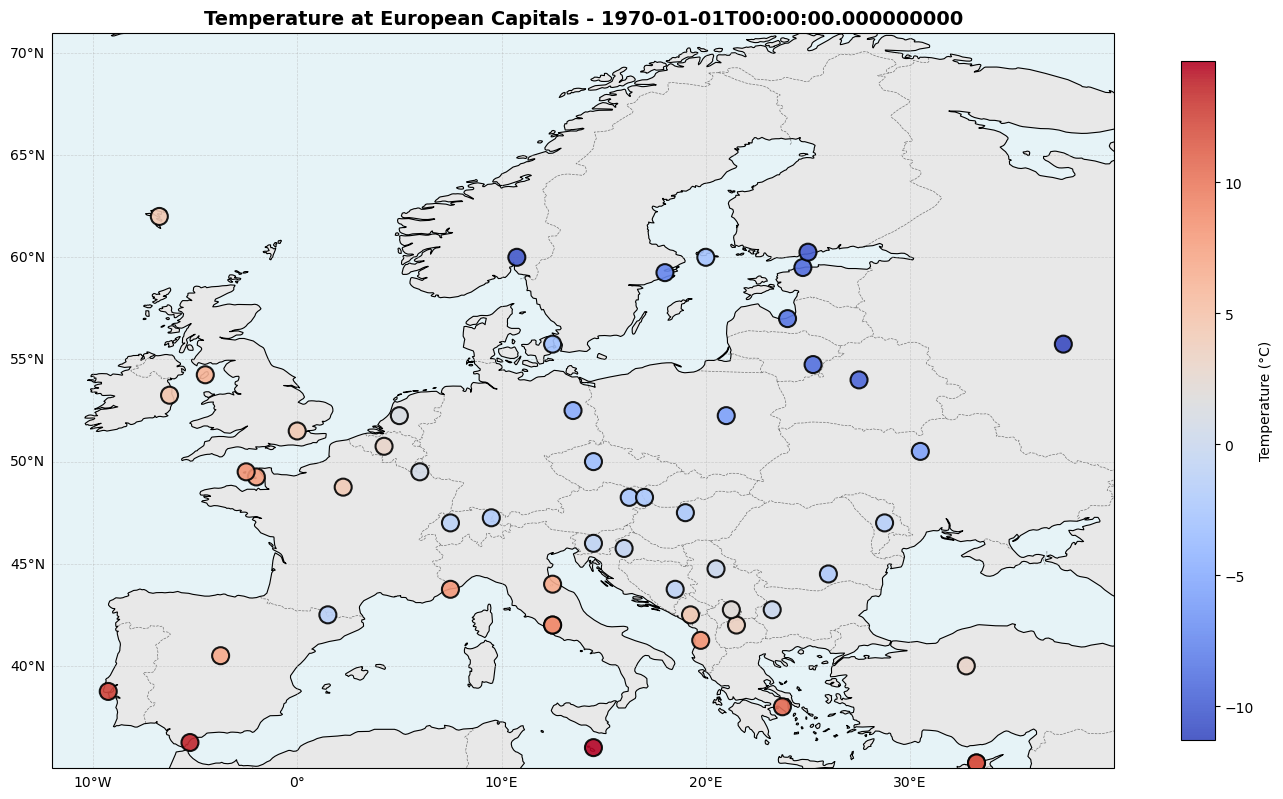

In [39]:
# Enhanced plot with Cartopy for better geographical representation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Extract the diagonal values (matching lat/lon pairs)
temps = np.diag(ds_capitals["t2m"][0].values) - 273.15  # Convert Kelvin to Celsius
lats = ds_capitals["t2m"].latitude.values
lons = ds_capitals["t2m"].longitude.values

# Plot scatter with correct transform
scatter = ax.scatter(lons, lats, c=temps, cmap='coolwarm', s=150, 
                        edgecolors='black', linewidths=1.5, 
                        transform=ccrs.PlateCarree(), zorder=5, alpha=0.9)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Temperature (°C)', shrink=0.7, pad=0.05)

# Set extent to focus on Europe (West, East, South, North)
ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title(f'Temperature at European Capitals - {ds_capitals["t2m"].time.values[0]}', 
                fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Average climate features for each decade

For each feature, for each capital (lat,lon), do the mean on 10 years for each month. For example, for the feature "2m temperature" (t2m), for the capital of France (48.8566, 2.3522), do the mean of all January data from 1970 to 1979, then do the mean of all February data from 1970 to 1979, and so on until December. Then repeat the same operation for the periods 1980-1989, 1990-1999, 2000-2009 and 2010-2020. In the end, we will have for each year, a dataset with 2 + 12 * 4 = 50 columns: latitude, longitude, and for each month (12) the 4 features (sf, tp, t2m, si10).

<img src="images/ds_columns_past.png" style="width:600px;"  />


In [44]:
# Define the periods for averaging
periods = [
    ('1970-1979', '1970-01', '1979-12'),
    ('1980-1989', '1980-01', '1989-12'),
    ('1990-1999', '1990-01', '1999-12'),
    ('2000-2009', '2000-01', '2009-12'),
    ('2010-2020', '2010-01', '2020-12')
]

# Dictionary to store separate DataFrames for each period
period_datasets = {}

for period_name, start_date, end_date in periods:
    print(f"Processing period: {period_name}")
    
    # List to store data for each capital
    capital_data = []
    
    # Iterate over each capital
    for idx in range(len(lats)):
        lat = lats[idx]
        lon = lons[idx]
        
        # Dictionary to store this capital's data
        row_data = {
            'latitude': lat,
            'longitude': lon
        }
        
        # For each feature, calculate monthly averages
        for feat in features:
            # Select data for this capital and time period
            # Extract diagonal to get the correct lat/lon pair
            data_period = ds_capitals[feat].sel(time=slice(start_date, end_date))
            
            # Get the diagonal values for this capital across all time steps in the period
            capital_timeseries = data_period.values[:, idx, idx]
            
            # Get the time index
            time_index = data_period.time.values
            
            # Convert to pandas Series for easier grouping by month
            ts = pd.Series(capital_timeseries, index=pd.DatetimeIndex(time_index))
            
            # Group by month and calculate mean
            monthly_means = ts.groupby(ts.index.month).mean()
            
            # Store each month's mean with column name like 'sf_jan', 'sf_feb', etc.
            month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
            
            for month_num, month_name in enumerate(month_names, start=1):
                if month_num in monthly_means.index:
                    row_data[f'{feat}_{month_name}'] = monthly_means[month_num]
                else:
                    row_data[f'{feat}_{month_name}'] = np.nan
        
        capital_data.append(row_data)
    
    # Create DataFrame for this period
    period_df = pd.DataFrame(capital_data)
    period_datasets[period_name] = period_df
    print(f"  Shape: {period_df.shape}")

print(f"\nCreated {len(period_datasets)} separate DataFrames")
print(f"Available periods: {list(period_datasets.keys())}")
print(f"\nExample - First few rows of 1970-1979:")
period_datasets['1970-1979'].head()

Processing period: 1970-1979
  Shape: (58, 50)
Processing period: 1980-1989
  Shape: (58, 50)
Processing period: 1980-1989
  Shape: (58, 50)
Processing period: 1990-1999
  Shape: (58, 50)
Processing period: 1990-1999
  Shape: (58, 50)
Processing period: 2000-2009
  Shape: (58, 50)
Processing period: 2000-2009
  Shape: (58, 50)
Processing period: 2010-2020
  Shape: (58, 50)
Processing period: 2010-2020
  Shape: (58, 50)

Created 5 separate DataFrames
Available periods: ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']

Example - First few rows of 1970-1979:
  Shape: (58, 50)

Created 5 separate DataFrames
Available periods: ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']

Example - First few rows of 1970-1979:


,latitude,longitude,sf_jan,sf_feb,sf_mar,sf_apr,sf_may,sf_jun,sf_jul,sf_aug,...,si10_mar,si10_apr,si10_may,si10_jun,si10_jul,si10_aug,si10_sep,si10_oct,si10_nov,si10_dec
0,35.25,33.25,0.000003,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.590315,2.754211,2.430504,2.676228,2.746363,2.569854,2.357226,2.120899,2.186576,2.403610
1,35.25,33.25,0.000003,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.590315,2.754211,2.430504,2.676228,2.746363,2.569854,2.357226,2.120899,2.186576,2.403610
2,36.00,14.50,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,7.159504,7.126379,5.361705,4.849958,4.529420,4.284868,4.881127,5.843067,6.624003,6.863742
3,36.25,-5.25,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,5.474470,5.122302,5.014000,4.760554,4.513916,4.431890,4.744140,5.122144,5.027225,5.288669
4,38.00,23.75,0.000060,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,...,2.867341,2.609093,2.295006,2.434040,2.649830,2.830254,2.705249,2.922193,2.722001,2.780026


In [49]:
# Display info about each period dataset
for period_name, df in period_datasets.items():
    print(f"\n{period_name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.shape[1]}")
    
# Example: Access a specific period and show first 5 and last 5 rows
print("\n" + "="*50)
print("Example - Dataset for 2000-2009:")
print("\nFirst 5 rows:")
display(period_datasets['2000-2009'].head())
print("\nLast 5 rows:")
display(period_datasets['2000-2009'].tail())


1970-1979:
  Shape: (58, 50)
  Columns: 50

1980-1989:
  Shape: (58, 50)
  Columns: 50

1990-1999:
  Shape: (58, 50)
  Columns: 50

2000-2009:
  Shape: (58, 50)
  Columns: 50

2010-2020:
  Shape: (58, 50)
  Columns: 50

Example - Dataset for 2000-2009:

First 5 rows:


,latitude,longitude,sf_jan,sf_feb,sf_mar,sf_apr,sf_may,sf_jun,sf_jul,sf_aug,...,si10_mar,si10_apr,si10_may,si10_jun,si10_jul,si10_aug,si10_sep,si10_oct,si10_nov,si10_dec
0,35.25,33.25,3.337860e-07,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.596070,2.681213,2.578540,2.698814,2.686101,2.536061,2.442919,2.143060,2.263597,2.385489
1,35.25,33.25,3.337860e-07,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,2.596070,2.681213,2.578540,2.698814,2.686101,2.536061,2.442919,2.143060,2.263597,2.385489
2,36.00,14.50,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,6.857813,6.561584,5.380151,4.408775,4.255876,4.272926,5.083470,5.089300,6.623851,7.535782
3,36.25,-5.25,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,5.234498,5.175549,4.882837,4.851866,4.768865,4.585963,4.551073,4.409344,4.761449,5.412490
4,38.00,23.75,1.632690e-04,0.000007,0.0,0.0,0.0,0.0,0.0,0.0,...,2.853932,2.648108,2.482691,2.680748,2.924284,2.977760,2.559716,2.691180,2.540184,2.874209



Last 5 rows:


,latitude,longitude,sf_jan,sf_feb,sf_mar,sf_apr,sf_may,sf_jun,sf_jul,sf_aug,...,si10_mar,si10_apr,si10_may,si10_jun,si10_jul,si10_aug,si10_sep,si10_oct,si10_nov,si10_dec
53,60.00,20.00,0.000789,0.000546,0.000126,0.000000,0.000000,0.0,0.0,0.000000,...,6.368092,5.912610,5.602075,5.668394,5.337663,5.744118,6.777757,7.312151,8.044945,8.143741
54,60.25,25.00,0.001054,0.000916,0.000215,0.000001,0.000000,0.0,0.0,0.000000,...,3.636329,3.483166,3.577027,3.540953,3.356267,3.506911,3.917968,4.080365,4.235497,4.382827
55,62.00,-6.75,0.000493,0.000415,0.000179,0.000011,0.000000,0.0,0.0,0.000000,...,8.551612,7.812853,6.571021,6.046641,5.662370,6.008766,7.430199,8.627239,8.948387,8.974380
56,64.25,-22.00,0.001737,0.001358,0.000655,0.000040,0.000001,0.0,0.0,0.000036,...,4.482081,4.270324,3.964869,3.487413,3.369011,3.450563,4.303807,4.240179,4.562010,4.530020
57,72.00,15.75,0.002173,0.001949,0.001072,0.000226,0.000001,0.0,0.0,0.000008,...,8.942163,8.297620,7.430151,6.168907,6.194011,6.429518,7.761717,8.487273,8.448314,10.264956


In [48]:
# Download the datasets as CSV files
for period_name, df in period_datasets.items():
    df.to_csv(f"datasets/climate_features_{period_name}.csv", index=False)
    print(f"Saved climate_features_{period_name}.csv")

Saved climate_features_1970-1979.csv
Saved climate_features_1980-1989.csv
Saved climate_features_1990-1999.csv
Saved climate_features_2000-2009.csv
Saved climate_features_2010-2020.csv


# Exploratory analysis of the data

In [53]:
# Load the datasets back from CSV files

period_names = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']
loaded_datasets = {}

for period_name in period_names:
    loaded_datasets[period_name] = pd.read_csv(f"datasets/climate_features_{period_name}.csv")
    print(f"Loaded climate_features_{period_name}.csv with shape {loaded_datasets[period_name].shape}")
    # print the size in ko of the loaded dataset
    print(f"Size in ko: {loaded_datasets[period_name].memory_usage(deep=True).sum() / 1024}")

Loaded climate_features_1970-1979.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_1980-1989.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_1990-1999.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_2000-2009.csv with shape (58, 50)
Size in ko: 22.78515625
Loaded climate_features_2010-2020.csv with shape (58, 50)
Size in ko: 22.78515625


In [93]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [86]:
# Useful definitions
bern_lat = bern.latitude.values[0]
bern_lon = bern.longitude.values[0]

month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

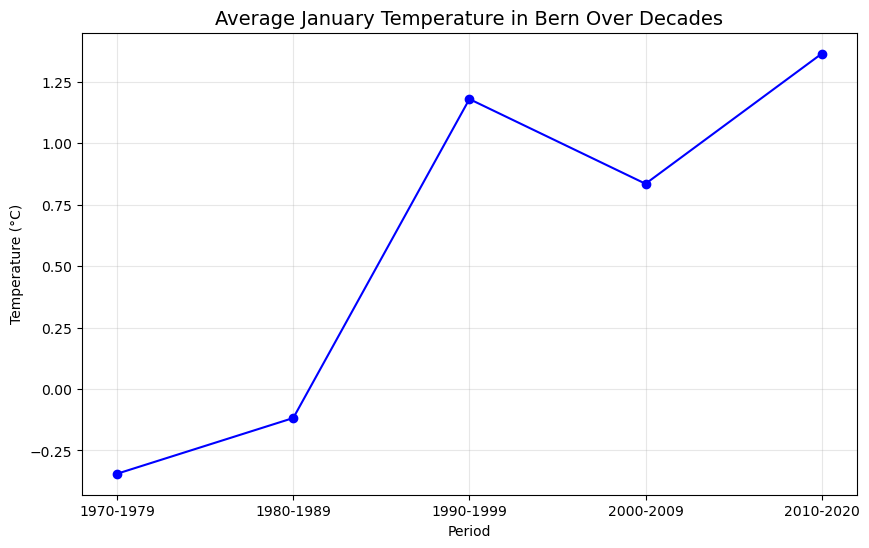

In [73]:
# Display the evolution of the temperature (t2m) in january for Bern over the decades

t2m_january = []
period_labels = []

for period_name in period_names:
    df = loaded_datasets[period_name]
    # Find the row corresponding to Bern
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    if not bern_row.empty:
        t2m_jan_value = bern_row['t2m_jan'].values[0]
        # Convert from Kelvin to Celsius
        t2m_january.append(t2m_jan_value - 273.15)  
        period_labels.append(period_name)
    else:
        t2m_january.append(np.nan)
        period_labels.append(period_name)

plt.figure(figsize=(10, 6))
plt.plot(period_labels, t2m_january, marker='o', linestyle='-', color='b', label='January')
plt.title('Average January Temperature in Bern Over Decades', fontsize=14)
plt.xlabel('Period')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

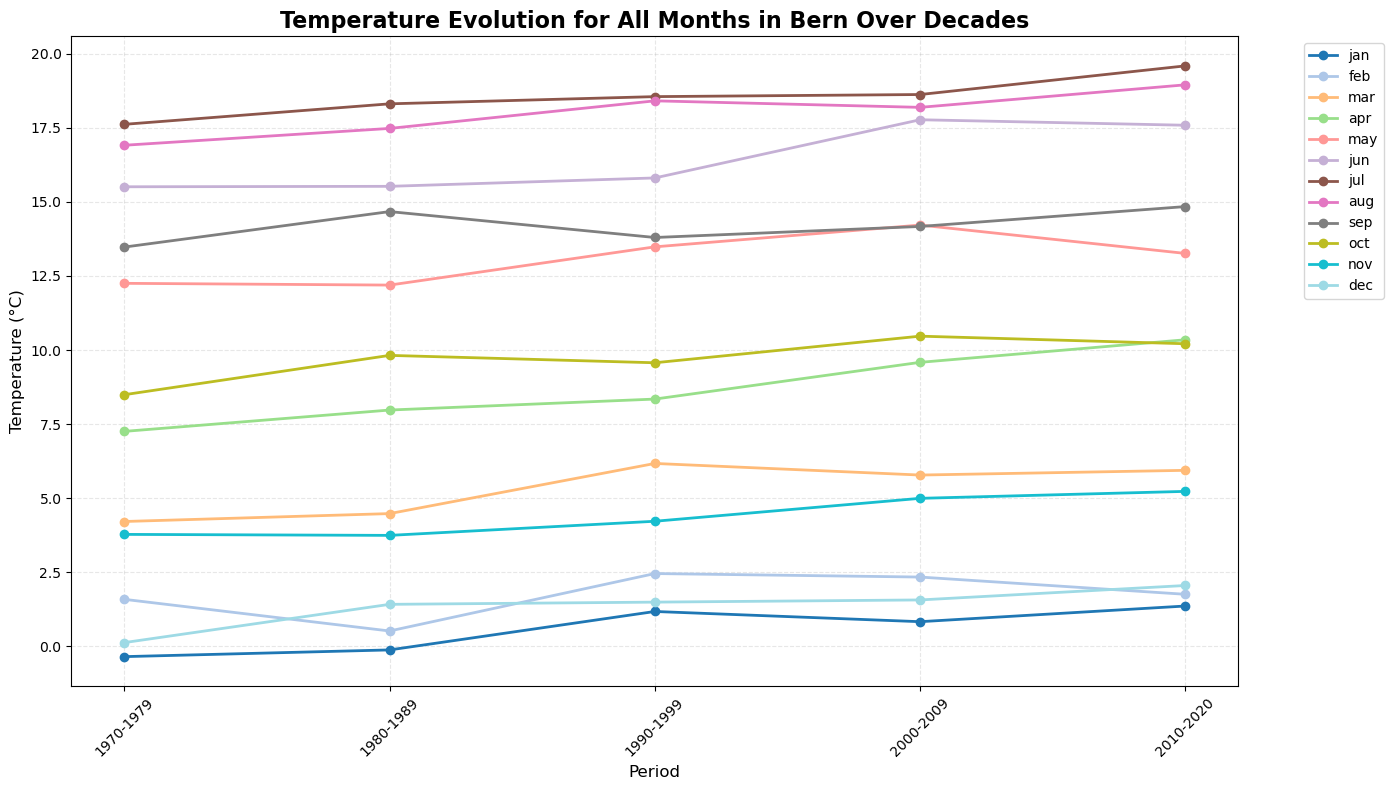

In [94]:
# Display the evolution of the temperature for all months in Bern over the decades

# Dictionary to store temperature data for each month
t2m_by_month = {month: [] for month in month_names}

# Extract data for each period
for period_name in period_names:
    df = loaded_datasets[period_name]
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    
    if not bern_row.empty:
        for month in month_names:
            t2m_value = bern_row[f't2m_{month}'].values[0]
            t2m_by_month[month].append(t2m_value - 273.15)  # Convert to Celsius
    else:
        for month in month_names:
            t2m_by_month[month].append(np.nan)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each month with a different color
colors = plt.cm.tab20(np.linspace(0, 1, 12))

for i, (month, label) in enumerate(zip(month_names, month_names)):
    ax.plot(period_names, t2m_by_month[month], 
            marker='o', linestyle='-', linewidth=2, 
            color=colors[i], label=label, markersize=6)

ax.set_title('Temperature Evolution for All Months in Bern Over Decades', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


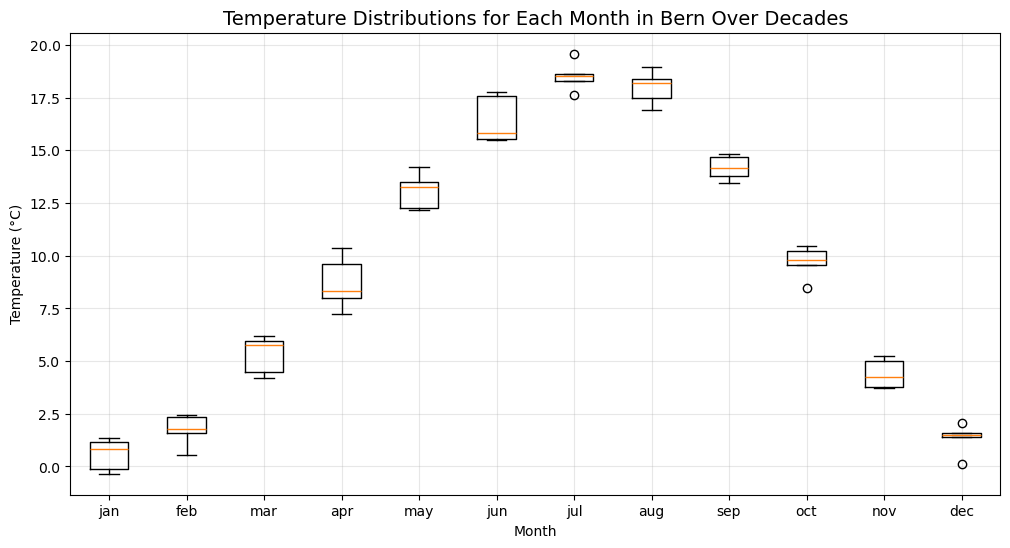

In [95]:
# Boxplots of temperature distributions for all  months in Bern over the decades

t2m_data = {month: [] for month in range(1, 13)}  # Dictionary to hold data for each month

for period_name in period_names:
    df = loaded_datasets[period_name]
    # Find the row corresponding to Bern
    bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]
    if not bern_row.empty:
        for month in range(1, 13):
            month_name = month_names[month - 1]
            t2m_value = bern_row[f't2m_{month_name}'].values[0]
            t2m_data[month].append(t2m_value - 273.15)  # Convert from Kelvin to Celsius
    else:
        for month in range(1, 13):
            t2m_data[month].append(np.nan)
# Prepare data for boxplot
boxplot_data = [t2m_data[month] for month in range(1, 13)]
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, tick_labels=month_names)
plt.title('Temperature Distributions for Each Month in Bern Over Decades', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

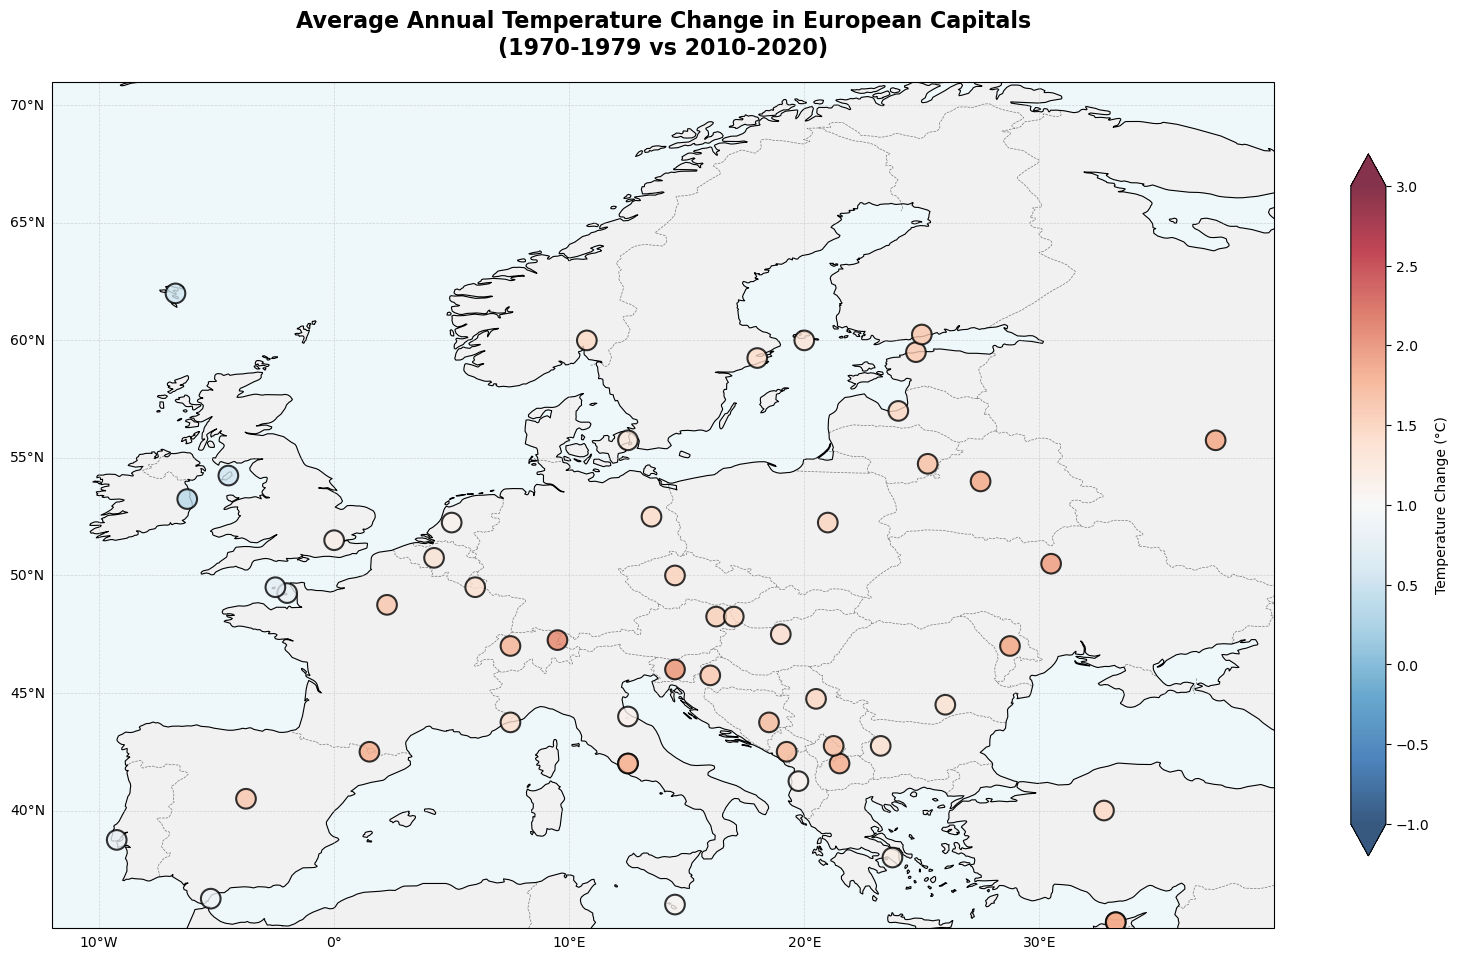

Average warming across all capitals: 1.42°C
Max warming: 2.32°C
Min warming: 0.44°C


In [97]:
# Map with temperature change across all European capitals

# Calculate temperature change between first and last period
df_1970 = loaded_datasets['1970-1979']
df_2010 = loaded_datasets['2010-2020']

temp_change = []
lats_plot = []
lons_plot = []

for _, row_70 in df_1970.iterrows():
    lat = row_70['latitude']
    lon = row_70['longitude']
    row_10 = df_2010[(df_2010['latitude'] == lat) & (df_2010['longitude'] == lon)]
    
    if not row_10.empty:
        # Calculate mean annual temperature for both periods
        temp_70 = np.mean([row_70[f't2m_{m}'] for m in month_names])
        temp_10 = np.mean([row_10.iloc[0][f't2m_{m}'] for m in month_names])
        change = temp_10 - temp_70  # Already in Kelvin, difference is same in Celsius
        temp_change.append(change)
        lats_plot.append(lat)
        lons_plot.append(lon)

fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Plot with diverging colormap (negative=cooling, positive=warming)
scatter = ax.scatter(lons_plot, lats_plot, c=temp_change, cmap='RdBu_r', 
                     s=200, edgecolors='black', linewidths=1.5,
                     transform=ccrs.PlateCarree(), zorder=5, alpha=0.8,
                     vmin=-1, vmax=3)

cbar = plt.colorbar(scatter, ax=ax, label='Temperature Change (°C)', 
                    shrink=0.6, pad=0.05, extend='both')

ax.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Average Annual Temperature Change in European Capitals\n(1970-1979 vs 2010-2020)', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"Average warming across all capitals: {np.mean(temp_change):.2f}°C")
print(f"Max warming: {np.max(temp_change):.2f}°C")
print(f"Min warming: {np.min(temp_change):.2f}°C")

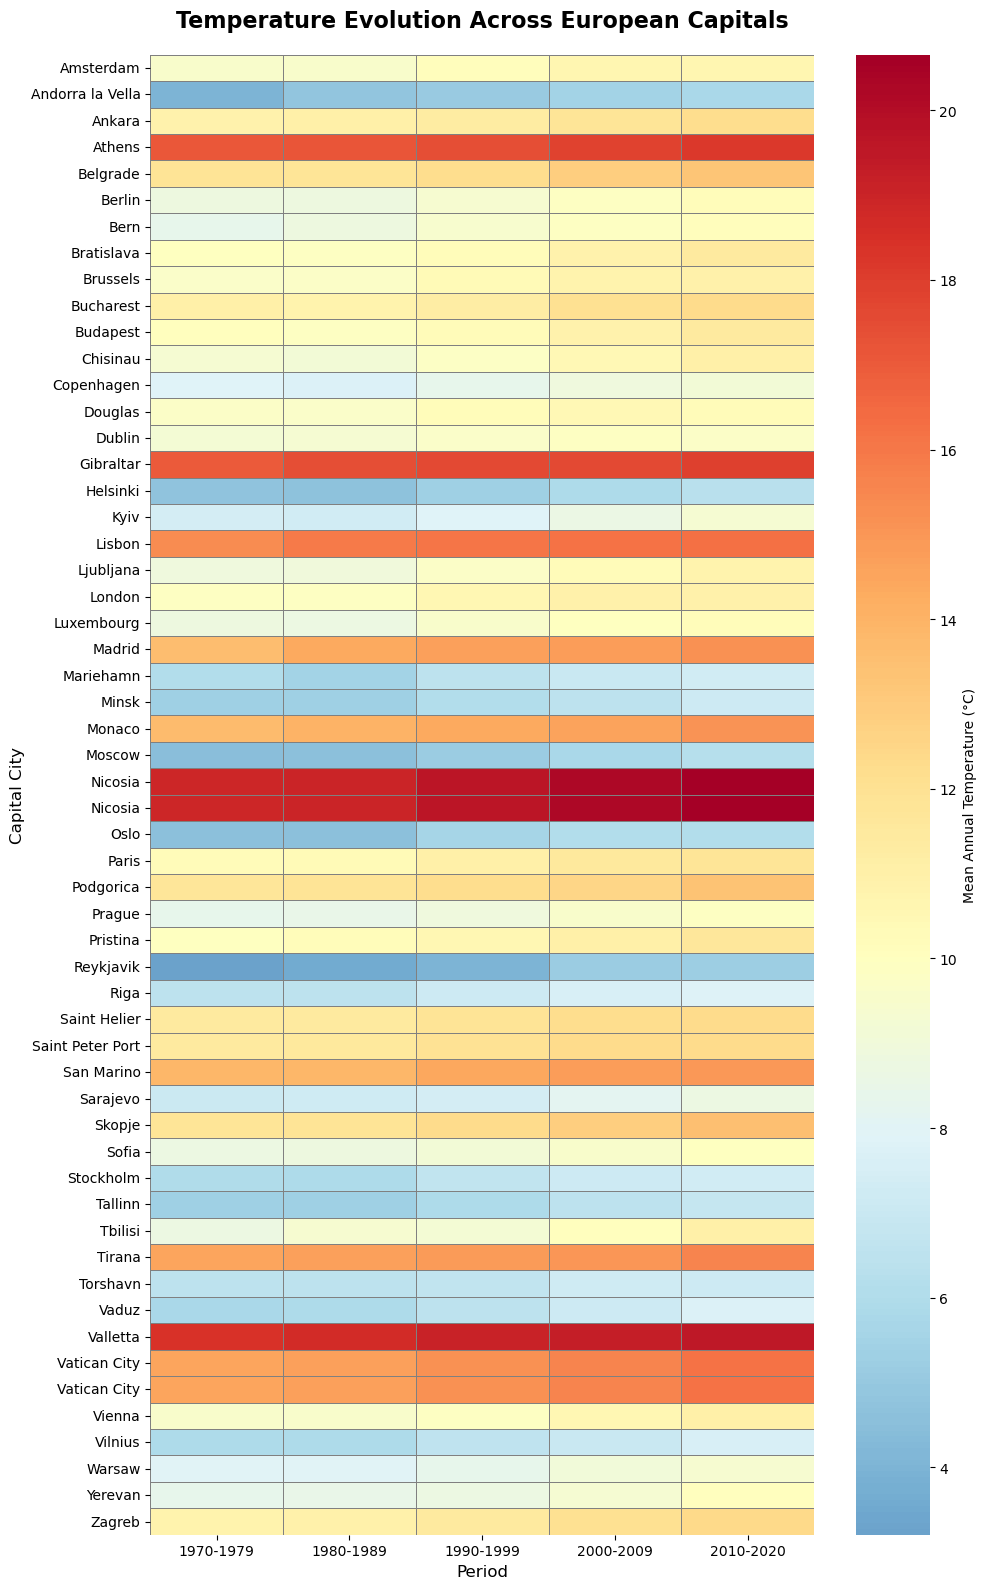

In [ ]:
# Heatmap of temperature evolution across all European capitals over the decades

# Prepare data: one row per capital, one column per period
capital_temps = []
capital_names_list = []

# Get capital names from eu_capitals
for _, row in df_1970.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    # Find capital name
    capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                          (eu_capitals['longitude'].round(4) == round(lon, 4))]
    
    if not capital.empty:
        name = capital.iloc[0]['name']
        capital_names_list.append(name)
        
        # Get mean annual temp for each period
        temps_by_period = []
        for period_name in period_names:
            df = loaded_datasets[period_name]
            row_data = df[(df['latitude'] == lat) & (df['longitude'] == lon)]
            if not row_data.empty:
                mean_temp = np.mean([row_data.iloc[0][f't2m_{m}'] for m in 
                                     month_names]) - 273.15
                temps_by_period.append(mean_temp)
        
        capital_temps.append(temps_by_period)

# Create DataFrame for heatmap
heatmap_df = pd.DataFrame(capital_temps, 
                          columns=period_names, 
                          index=capital_names_list)

# Sort by latitude (north to south)
heatmap_df = heatmap_df.sort_index()

plt.figure(figsize=(10, 16))
sns.heatmap(heatmap_df, cmap='RdYlBu_r', center=10, 
            cbar_kws={'label': 'Mean Annual Temperature (°C)'},
            linewidths=0.5, linecolor='gray', annot=False)
plt.title('Temperature Evolution Across European Capitals', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Capital City', fontsize=12)
plt.tight_layout()
plt.show()

Max SF: 0.0009999275
Min SF: 0.0
Max T2M: 292.73538
Min T2M: 274.51328
Max TP: 0.0044018137
Min TP: 0.002319336
Max SI10: 2.1732366
Min SI10: 1.5161611


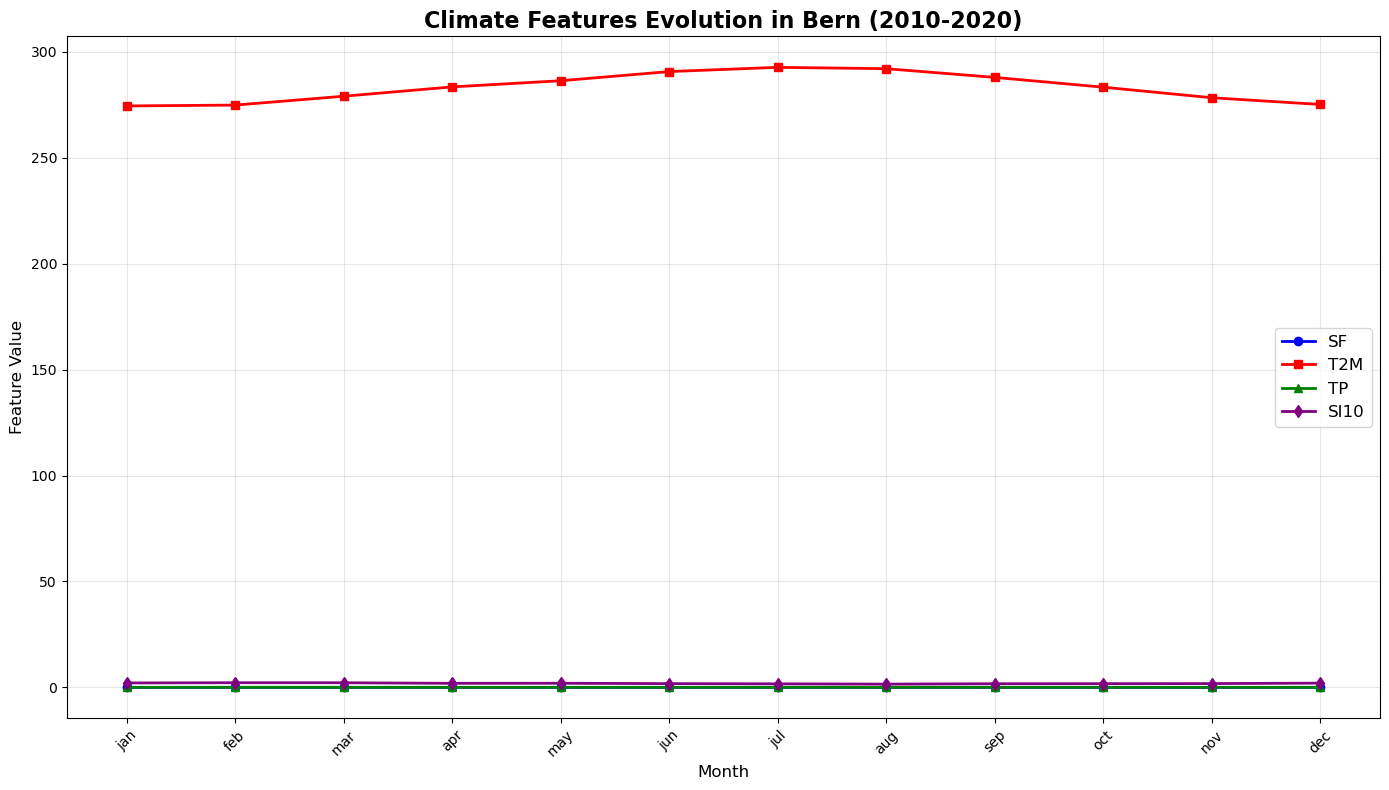

In [106]:
# Show all 4 features evolution per month for Bern in 2010-2020 on a single plot

features = ["sf", "t2m", "tp", "si10"]
period_name = '2010-2020'
df = loaded_datasets[period_name]

plt.figure(figsize=(14, 8))

bern_row = df[(df['latitude'] == bern_lat) & (df['longitude'] == bern_lon)]

if not bern_row.empty:
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'd']
    
    for i, feat in enumerate(features):
        values = [bern_row[f'{feat}_{m}'].values[0] for m in month_names]
        plt.plot(month_names, values, marker=markers[i], linestyle='-', 
                linewidth=2, color=colors[i], label=feat.upper(), markersize=6)
        print(f"Max {feat.upper()}: {max(values)}")
        print(f"Min {feat.upper()}: {min(values)}")

plt.title('Climate Features Evolution in Bern (2010-2020)', 
         fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Feature Value', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see that we really need to normalize the data before using it in a model, as the ranges of values for each feature are very different. 

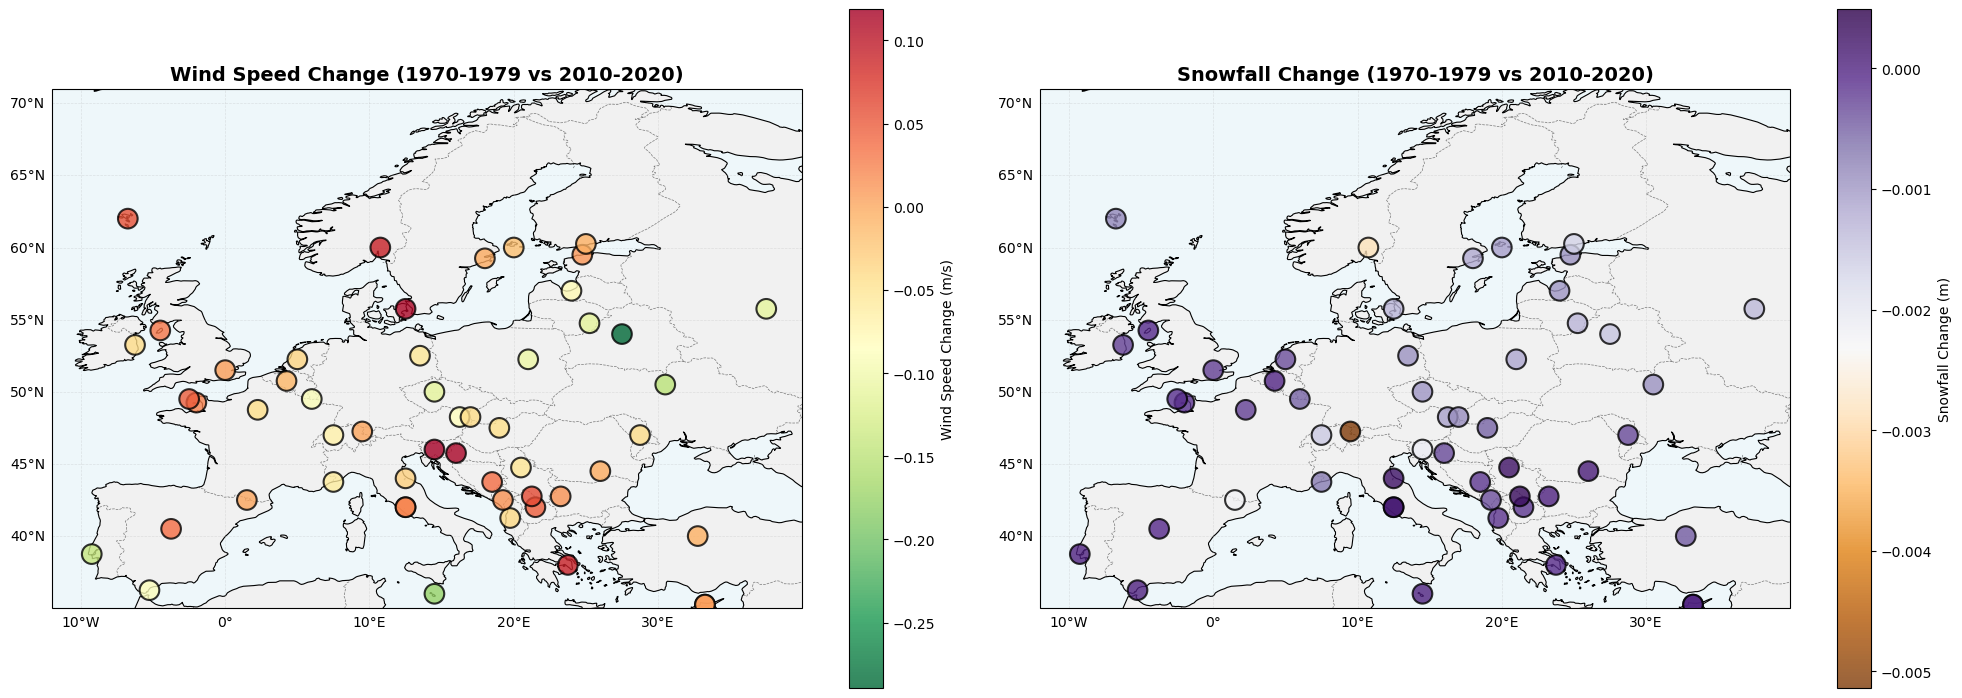

Average wind speed change: -0.018 m/s
Average snowfall change: -0.000711 m


In [ ]:
# Map showing wind speed and snowfall changes across European capitals

fig, axes = plt.subplots(1, 2, figsize=(20, 10), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Data collection
wind_change = []
snow_change = []
lats_plot = []
lons_plot = []

for _, row_70 in df_1970.iterrows():
    lat = row_70['latitude']
    lon = row_70['longitude']
    row_10 = df_2010[(df_2010['latitude'] == lat) & (df_2010['longitude'] == lon)]
    
    if not row_10.empty:
        # Wind change (annual mean)
        wind_70 = np.mean([row_70[f'si10_{m}'] for m in month_names])
        wind_10 = np.mean([row_10.iloc[0][f'si10_{m}'] for m in month_names])
        
        # Snowfall change (annual sum)
        snow_70 = np.sum([row_70[f'sf_{m}'] for m in month_names])
        snow_10 = np.sum([row_10.iloc[0][f'sf_{m}'] for m in month_names])
        
        wind_change.append(wind_10 - wind_70)
        snow_change.append(snow_10 - snow_70)
        lats_plot.append(lat)
        lons_plot.append(lon)

# Plot 1: Wind Speed Change
ax1 = axes[0]
ax1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

scatter1 = ax1.scatter(lons_plot, lats_plot, c=wind_change, cmap='RdYlGn_r', 
                       s=200, edgecolors='black', linewidths=1.5,
                       transform=ccrs.PlateCarree(), zorder=5, alpha=0.8)

cbar1 = plt.colorbar(scatter1, ax=ax1, label='Wind Speed Change (m/s)', 
                     shrink=0.7, pad=0.05)
ax1.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())
ax1.set_title('Wind Speed Change (1970-1979 vs 2010-2020)', 
              fontsize=14, fontweight='bold')

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot 2: Snowfall Change
ax2 = axes[1]
ax2.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--', alpha=0.5)
ax2.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

scatter2 = ax2.scatter(lons_plot, lats_plot, c=snow_change, cmap='PuOr', 
                       s=200, edgecolors='black', linewidths=1.5,
                       transform=ccrs.PlateCarree(), zorder=5, alpha=0.8)

cbar2 = plt.colorbar(scatter2, ax=ax2, label='Snowfall Change (m)', 
                     shrink=0.7, pad=0.05)
ax2.set_extent([-12, 40, 35, 71], crs=ccrs.PlateCarree())
ax2.set_title('Snowfall Change (1970-1979 vs 2010-2020)', 
              fontsize=14, fontweight='bold')

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

plt.tight_layout()
plt.show()

print(f"Average wind speed change: {np.mean(wind_change):.3f} m/s")
print(f"Average snowfall change: {np.mean(snow_change):.6f} m")

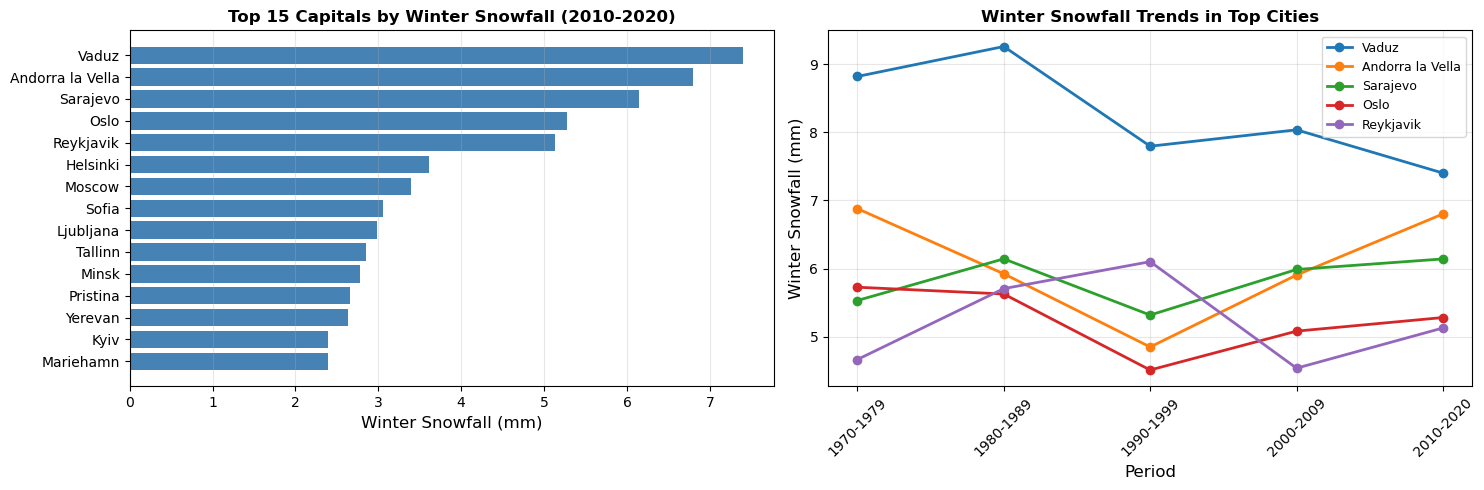

In [128]:
# Focus on winter snowfall and summer wind patterns

fig, axes = plt.subplots(1,2, figsize=(15, 5))

winter_months = ['dec', 'jan', 'feb']

# Winter Snowfall by Capital
ax1 = axes[0]
winter_snow = []
capital_names_winter = []

for _, row in df_2010.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                          (eu_capitals['longitude'].round(4) == round(lon, 4))]
    
    if not capital.empty:
        name = capital.iloc[0]['name']
        snow_sum = sum([row[f'sf_{m}'] * 1000 for m in winter_months])
        winter_snow.append(snow_sum)
        capital_names_winter.append(name)

# Sort by snowfall
sorted_indices = np.argsort(winter_snow)[::-1][:15]  # Top 15
ax1.barh([capital_names_winter[i] for i in sorted_indices[::-1]],
         [winter_snow[i] for i in sorted_indices[::-1]],
         color='steelblue')
ax1.set_xlabel('Winter Snowfall (mm)', fontsize=12)
ax1.set_title('Top 15 Capitals by Winter Snowfall (2010-2020)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Snowfall decline over decades for top cities
ax2 = axes[1]
top_cities = [capital_names_winter[i] for i in sorted_indices[:5]]

for city in top_cities:
    city_snow_evolution = []
    for period_name in period_names:
        df = loaded_datasets[period_name]
        for _, row in df.iterrows():
            lat = row['latitude']
            lon = row['longitude']
            capital = eu_capitals[(eu_capitals['latitude'].round(4) == round(lat, 4)) & 
                                  (eu_capitals['longitude'].round(4) == round(lon, 4))]
            
            if not capital.empty and capital.iloc[0]['name'] == city:
                snow_sum = sum([row[f'sf_{m}'] * 1000 for m in winter_months])
                city_snow_evolution.append(snow_sum)
                break
    
    ax2.plot(period_names, city_snow_evolution, marker='o', linewidth=2, 
             label=city, markersize=6)

ax2.set_title('Winter Snowfall Trends in Top Cities', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Period', fontsize=12)
ax2.set_ylabel('Winter Snowfall (mm)', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()